In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonavg
from funzioni import plot_zonavg_2_cluster
from funzioni import plot_mean_cluster_zonavg
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonavg
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs

Caricamento dei file pickle

In [2]:
# Caricamento di models e models_atmos
with open('models.pkl', 'rb') as file:
    models = dill.load(file)
#Caricamento dei file pickle di modelli_tos
with open('modelli_tos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0_pca = pickle.load(f)
    list_cluster1_pca = pickle.load(f)
    list_cluster2_pca = pickle.load(f)
    list_cluster3_pca = pickle.load(f)
    list_cluster4_pca = pickle.load(f)
    
    # Caricamento dei 5 cluster in formato pdf
    cluster_0_pdf = pickle.load(f)
    cluster_1_pdf = pickle.load(f)
    cluster_2_pdf = pickle.load(f)
    cluster_3_pdf = pickle.load(f)
    cluster_4_pdf = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    cluster_0_mean_pdf = pickle.load(f)
    cluster_1_mean_pdf = pickle.load(f)
    cluster_2_mean_pdf = pickle.load(f)
    cluster_3_mean_pdf = pickle.load(f)
    cluster_4_mean_pdf = pickle.load(f)

In [3]:
list_cluster0 = list_cluster0_pca
list_cluster1 = list_cluster1_pca
list_cluster2 = list_cluster2_pca
list_cluster3 = list_cluster3_pca
list_cluster4 = list_cluster4_pca

Posizione della corrente del Golfo

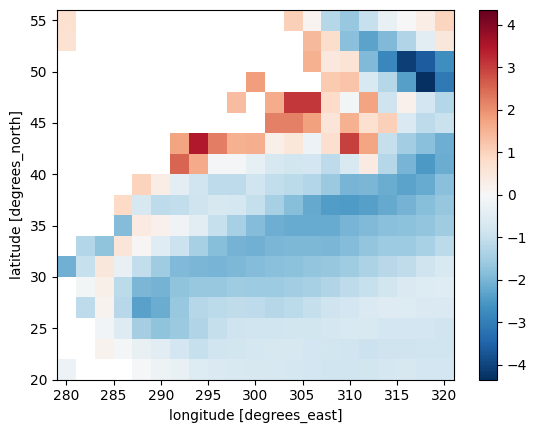

In [6]:
models['ACCESS-CM2']['North Atlantic bias DJF'].sel(lon=slice(280,320), lat=slice(20,55)).plot()

In [68]:
#seleziono un sottobox in cui vado a cercare la corrente del Golfo
for name in models.keys():
    models[name]['GS box bias DJF'] = models[name]['North Atlantic bias DJF'].sel(lon=slice(282,320), lat=slice(20,55)) #box Gulf Stream

Cluster 0 GS

è sui cluster medi che devo calcolare il pt di separazione della corrente del Golfo


In [69]:
n_clusters = 5 #number clusters
list_clusters = [list_cluster0,list_cluster1,list_cluster2,list_cluster3,list_cluster4]
mean_cluster = [[] for _ in range(n_clusters)] #inizializzo con una lista vuota per ogni cluster
for n in range(n_clusters): #ciclo sui cluster    
    for i in range(len(list_clusters)): #ciclo su tutte le liste
        sum_bias = 0
        for j in range(len(list_clusters[i])): #ciclo sui singoli modelli della lista i-esima
            model_name = list_clusters[i][j] #modello j-esimo della lista i-esima
            sum_bias = sum_bias + models[model_name]['GS box bias DJF']
        mean_cluster[i].append(sum_bias / len(list_clusters[i])) #media

In [70]:
#Ricerca del valore massimo sulla latitudine, a longitudine fissata
array_max = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box bias DJF'].lat),len(models[list_cluster0[0]]['GS box bias DJF'].lon))) #di dimesnioni 5xlatxlon
for n in range(n_clusters): #ciclo sui 5 cluster
    max_value = -999 #inizializzo il valore massimo
    for j in range(len(models[list_cluster0[0]]['GS box bias DJF'].lon)): #ciclo sulle longitudini
        array_lon = mean_cluster[n][0][:,j] #array (n,plev=0,tutte le lat,lon=j)
        index_max_value = array_lon.argmax() #determino l'indice del valore massimo
        for i in range(len(models[list_cluster0[0]]['GS box bias DJF'].lat)): #ciclo sulle latitudini, a longitudine fissa
            if i == index_max_value: #se valore massimo metto 1 nella matrice array_max
                array_max[n,i,j] = 1
            else:
                array_max[n,i,j] = 0

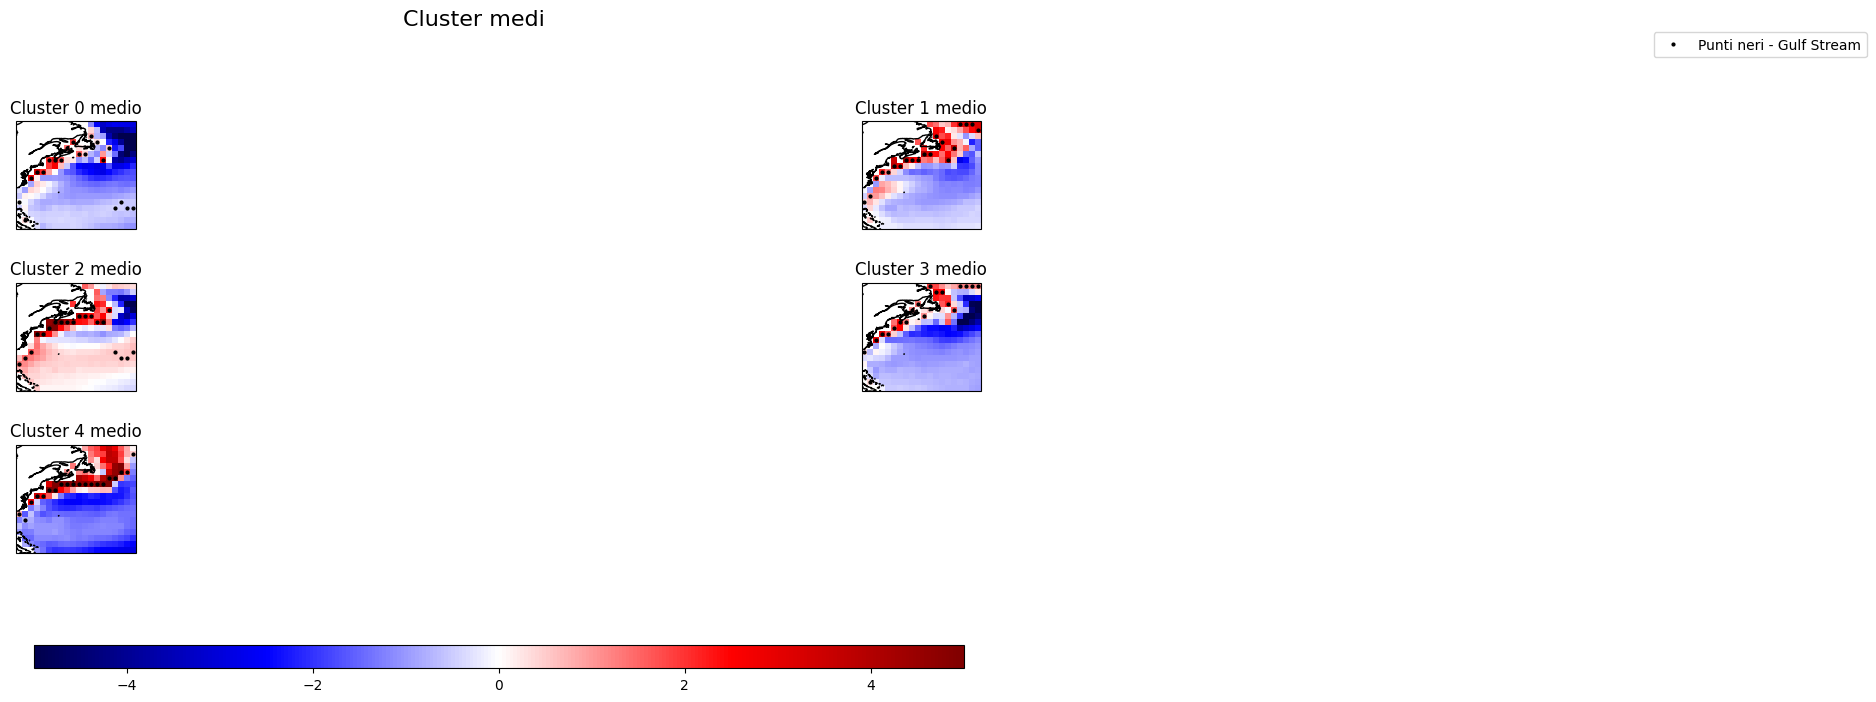

In [77]:
#Plot dei cluster medi
fig, ax = plt.subplots(nrows=int(n_clusters/2)+1, ncols=int(n_clusters/2), figsize=(20,8),subplot_kw={"projection": ccrs.PlateCarree()}) #trasformazione cartografica = lonxlat
fig.subplots_adjust(hspace=0.5, wspace=0.2)  # Aggiungo spazi verticali e orizzontali tra le subplots
for i in range(int(n_clusters/2)+1): # Ciclo sui 5 cluster medi
    for j in range(int(n_clusters/2)):
        index = i*(int(n_clusters/2))+j
        if index == n_clusters:
            break
        plot_mod = ax[i,j].pcolormesh(mean_cluster[index][0].lon, mean_cluster[index][0].lat, mean_cluster[index][0], cmap='seismic', vmin=-5, vmax=5)        
        coords = np.where(array_max[index,::] == 1) #array di valori di longitudini e latitudini in cui array_max = 1
        # Plot dei punti solo dove matrix10 è uguale a 1
        ax[i,j].plot(mean_cluster[index][0].lon[coords[1]], mean_cluster[index][0].lat[coords[0]], marker='o', color='black', markersize=2, linestyle='None', transform=ccrs.PlateCarree())
        ax[i,j].coastlines() # Aggiungo le coste
        # Label degli assi
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')
        ax[i,j].set_title(f'Cluster {index} medio') 


#Rimuovo i quadrati non utilizzati
for i in range(int(n_clusters/2)+1):
    for j in range(int(n_clusters/2)):
        index = i * int(n_clusters/2) + j
        if index >= n_clusters:
            ax[i,j].axis('off')

# Titolo
fig.colorbar(plot_mod, ax=ax, orientation='horizontal', shrink=0.6, aspect=40)
# Legenda per linee tratteggiate
fig.legend(['Punti neri - Gulf Stream'], loc='upper right', bbox_to_anchor=(1.2, 1))
fig.suptitle('Cluster medi', fontsize=16, y=1.02)

fig.show()